In [193]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [194]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE


Tensorflow version 2.13.0


In [195]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [196]:
data_dir=Path("/kaggle/input/captchaimgdata/trainset")
images=sorted(list(map(str,list(data_dir.glob("*.jpeg")))))



display(images[0])

labels=[img.split(os.path.sep)[-1].split(".jpeg")[0] for img in images]

# print(labels)

characters=set(char for label in labels for char in label)
print(characters) 
characters=sorted(list(characters))

'/kaggle/input/captchaimgdata/trainset/222374.jpeg'

{'4', 'C', 'H', 'Y', 'V', 'Z', 'y', 'P', 'S', 'U', 's', 'L', '2', 'j', 'M', 'E', 'B', 'c', 'K', 'W', 'X', 'x', 'R', 'G', '5', '8', 'N', 'w', 'u', 'T', '7', 'A', '9', 'J', '3', 'D', '6', 'F'}


In [197]:
batch_size = 24
sample=Image.open(images[0])
image_height, image_width=(50, 198) #198,50
print(image_width,image_height)

downsample_factor=2

198 50


In [198]:
max_length = max([len(label) for label in labels])
display(max_length)

6

In [199]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup
char_to_num=layers.StringLookup(vocabulary=list(characters),mask_token=None)

num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [200]:
def encode_single_sample(img_path,label):
    img=tf.io.read_file(img_path)
    img=tf.io.decode_jpeg(img,channels=1)
    img=tf.image.convert_image_dtype(img,tf.float32)
#     img=tf.image.resize(img,[image_width,image_height])
    label=char_to_num(tf.strings.unicode_split(label,input_encoding="UTF-8"))
    
    return {"image": img, "label": label}

In [201]:
print(encode_single_sample(images[0],labels[0]))

{'image': <tf.Tensor: shape=(50, 198, 1), dtype=float32, numpy=
array([[[0.8352942 ],
        [0.8313726 ],
        [0.8313726 ],
        ...,
        [0.6745098 ],
        [0.6745098 ],
        [0.67058825]],

       [[0.8235295 ],
        [0.8235295 ],
        [0.8196079 ],
        ...,
        [0.65882355],
        [0.65882355],
        [0.654902  ]],

       [[0.8431373 ],
        [0.8431373 ],
        [0.8431373 ],
        ...,
        [0.654902  ],
        [0.6509804 ],
        [0.6509804 ]],

       ...,

       [[0.8235295 ],
        [0.8235295 ],
        [0.8235295 ],
        ...,
        [0.654902  ],
        [0.6509804 ],
        [0.6509804 ]],

       [[0.8235295 ],
        [0.8196079 ],
        [0.8196079 ],
        ...,
        [0.6509804 ],
        [0.64705884],
        [0.64705884]],

       [[0.8235295 ],
        [0.8196079 ],
        [0.8196079 ],
        ...,
        [0.6509804 ],
        [0.64705884],
        [0.64705884]]], dtype=float32)>, 'label': <tf.Tensor: sha

In [202]:
def split_data(images,labels,train_size=0.95,shuffle=True):
    size=len(images)
    indices=np.arange(size)
    if(shuffle):
        np.random.shuffle(indices)
    train_samples= int(size*train_size)    
    
    x_train,y_train=images[indices[:train_samples]],labels[indices[:train_samples]]
    x_val,y_val=images[indices[train_samples:]],labels[indices[train_samples:]]
    
    return x_train,y_train,x_val,y_val

In [203]:
x_train, y_train, x_val, y_val = split_data(np.array(images), np.array(labels))

In [204]:
print(x_train.size, x_val.size)

24847 1308


In [205]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = (validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

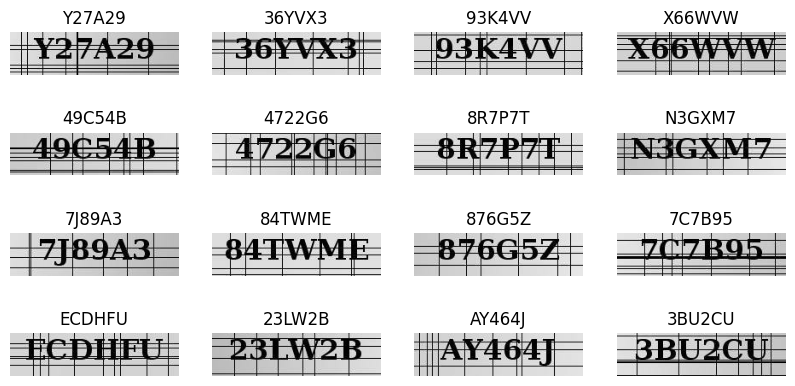

In [206]:
_,ax=plt.subplots(4,4,figsize=(10,5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img=(images[i]*255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i//4, i % 4].imshow(img[:, :, 0], cmap="gray",aspect="1")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
        
plt.show()  

Y27A29
(50, 198, 1)


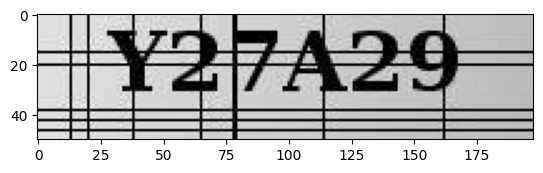

In [207]:
#single sample
image=batch["image"][0]
label=batch["label"][0]
img=(image*255).numpy().astype("uint8")
labl= tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
image = Image.fromarray(img.squeeze())
plt.imshow(image,cmap="gray",aspect="1")
print(labl)
print(img.shape)

In [208]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)


        return y_pred

In [209]:
def inception_block(x, filters):
    # Each branch is a stack of layers with a common input 'x' and different filter operations
    branch1x1 = layers.Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu')(x)

    branch3x3 = layers.Conv2D(filters=filters[1], kernel_size=(1, 1), padding='same', activation='relu')(x)
    branch3x3 = layers.Conv2D(filters=filters[2], kernel_size=(3, 3), padding='same', activation='relu')(branch3x3)

    branch5x5 = layers.Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu')(x)
    branch5x5 = layers.Conv2D(filters=filters[4], kernel_size=(5, 5), padding='same', activation='relu')(branch5x5)

    branch_pool = layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = layers.Conv2D(filters=filters[5], kernel_size=(1, 1), padding='same', activation='relu')(branch_pool)

    # Concatenate the outputs (on the channel dimension) of each branch
    output = layers.Concatenate(axis=-1)([branch1x1, branch3x3, branch5x5, branch_pool])
    return output

In [210]:
def build_model():

    input_img = layers.Input(
        shape=(image_height, image_width, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")


    x = layers.Conv2D(
        32,
        (5, 5),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = layers.Dropout(0.2)(x)

    x = inception_block(x, filters=[32, 48, 64, 16, 32, 32])

    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    x = layers.Dropout(0.2)(x)

    new_shape = ((image_height // 4), (image_width // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.4)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)


    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)


    output = CTCLayer(name="ctc_loss")(labels, x)


    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )

    opt = keras.optimizers.Adam()

    model.compile(optimizer=opt)
    return model



model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 50, 198, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 50, 198, 32)          832       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 25, 99, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 dropout_22 (Dropout)        (None, 25, 99, 32)           0         ['pool1[0][0]']               
                                                                                       

In [211]:
epochs = 100
early_stopping_patience = 5

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)


history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100


2024-01-09 04:12:04.617090: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inocr_model_v1/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1036/1036 [==============================] - 46s 35ms/step - loss: 20.9646 - val_loss: 19.8753
Epoch 2/100
1036/1036 [==============================] - 34s 33ms/step - loss: 17.5192 - val_loss: 13.5650
Epoch 3/100
1036/1036 [==============================] - 34s 33ms/step - loss: 13.5088 - val_loss: 9.8730
Epoch 4/100
1036/1036 [==============================] - 35s 33ms/step - loss: 10.6268 - val_loss: 6.6903
Epoch 5/100
1036/1036 [==============================] - 35s 33ms/step - loss: 8.5754 - val_loss: 4.8354
Epoch 6/100
1036/1036 [==============================] - 35s 33ms/step - loss: 6.9673 - val_loss: 3.3955
Epoch 7/100
1036/1036 [==============================] - 34s 33ms/step - loss: 5.7650 - val_loss: 2.7735
Epoch 8/100
1036/1036 [==============================] - 34s 33ms/step - loss: 4.9781 - val_loss: 2.2550
Epoch 9/100
1036/1036 [==============================] - 34s 33ms/step - loss: 4.4192 - val_loss: 1.9394
Epoch 10/100
1036/1036 [==============================] - 34s

In [212]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 50, 198, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 50, 198, 32)          832       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 25, 99, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 dropout_22 (Dropout)        (None, 25, 99, 32)           0         ['pool1[0][0]']               
                                                                                            

In [213]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]

    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

1/1 [==============================] - 1s 1s/step
accuracy of prediction = 83.33333333333334
1/1 [==============================] - 0s 26ms/step
accuracy of prediction = 91.66666666666666
1/1 [==============================] - 0s 25ms/step
accuracy of prediction = 91.66666666666666
1/1 [==============================] - 0s 30ms/step
accuracy of prediction = 91.66666666666666
1/1 [==============================] - 0s 29ms/step
accuracy of prediction = 87.5
1/1 [==============================] - 0s 30ms/step
accuracy of prediction = 100.0
1/1 [==============================] - 0s 28ms/step
accuracy of prediction = 91.66666666666666
1/1 [==============================] - 0s 27ms/step
accuracy of prediction = 79.16666666666666
1/1 [==============================] - 0s 26ms/step
accuracy of prediction = 95.83333333333334
1/1 [==============================] - 0s 26ms/step
accuracy of prediction = 100.0


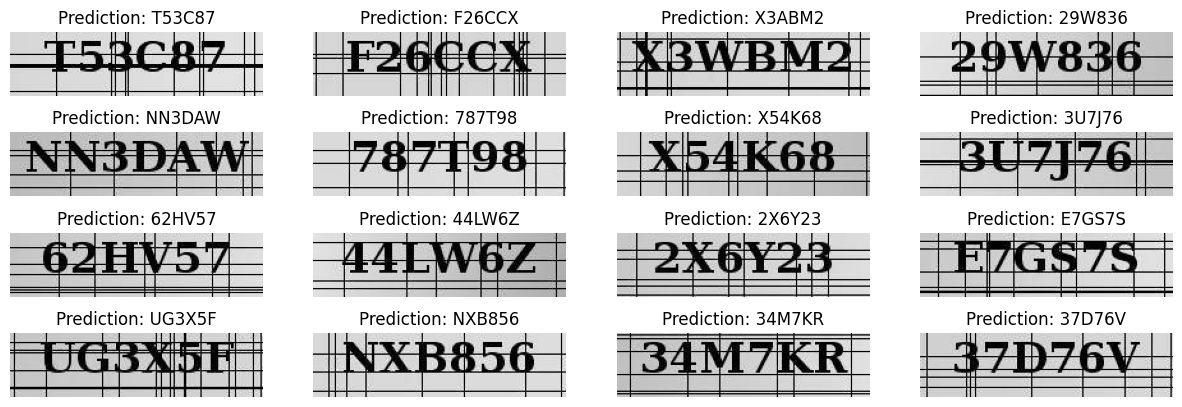

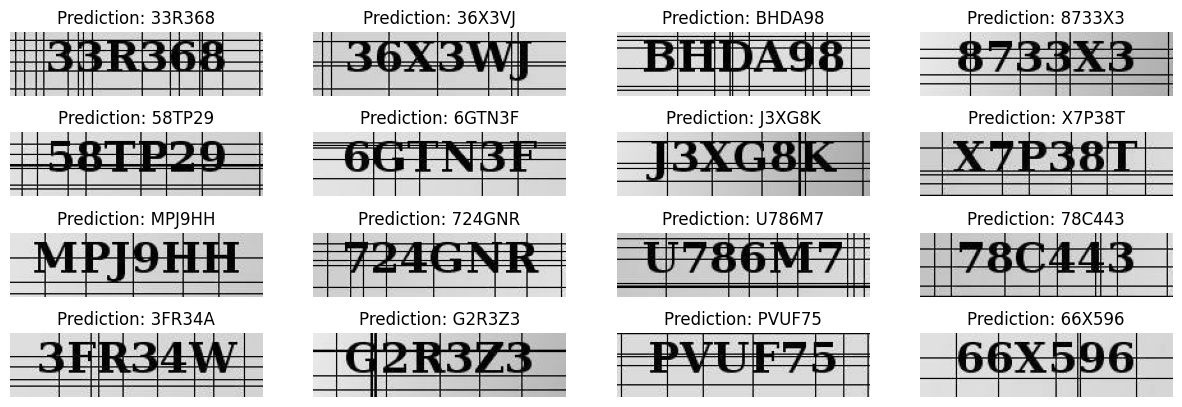

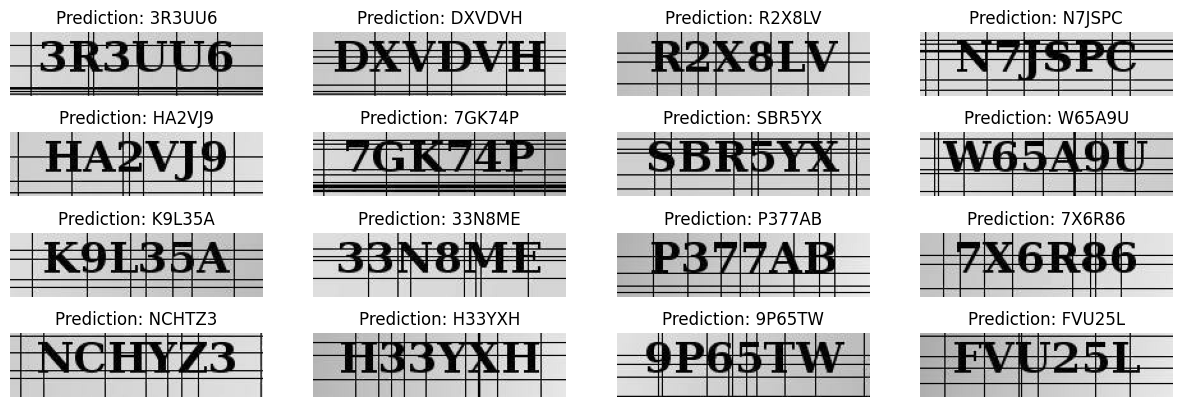

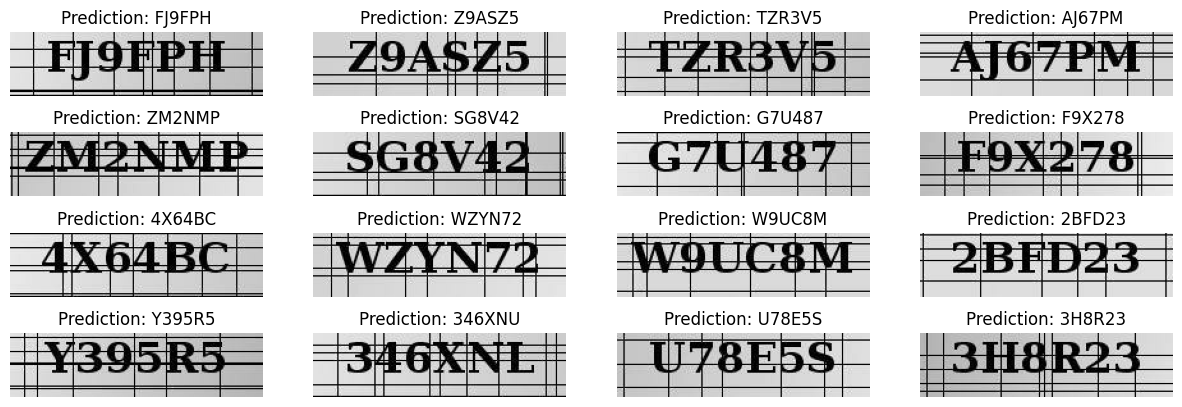

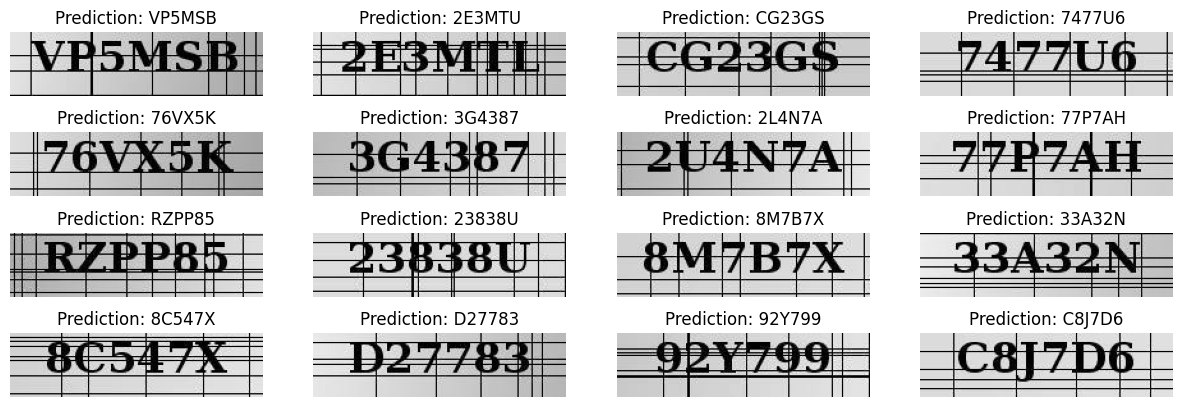

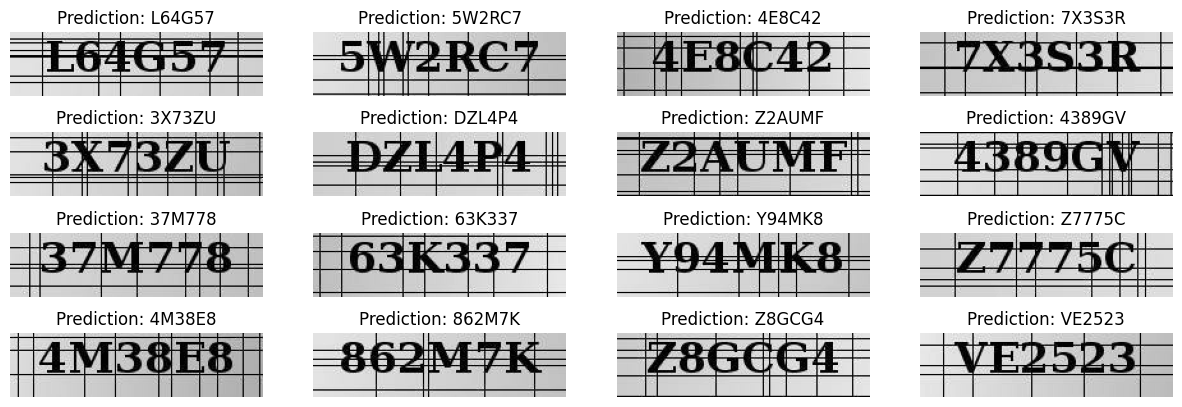

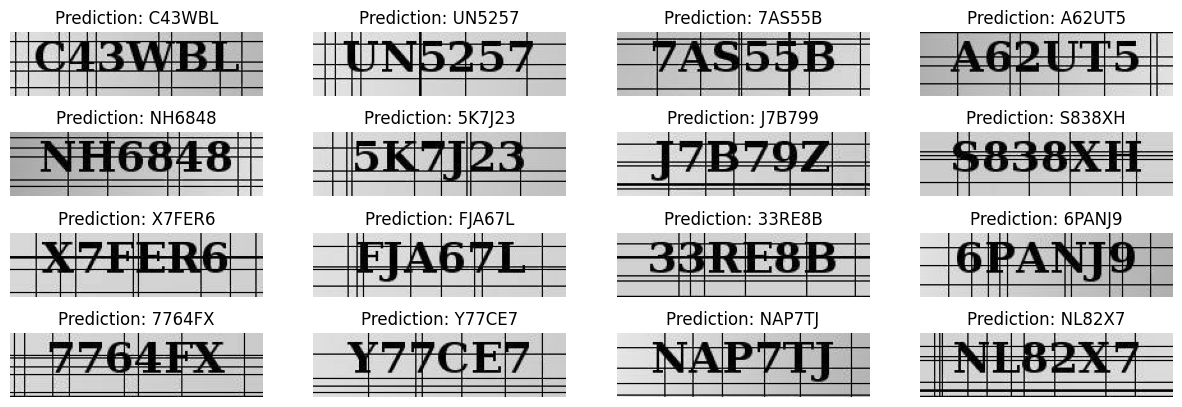

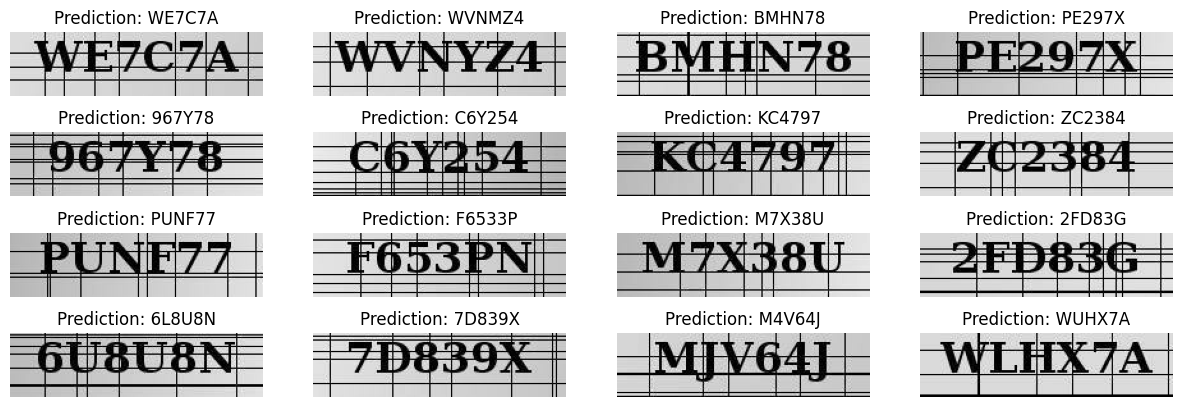

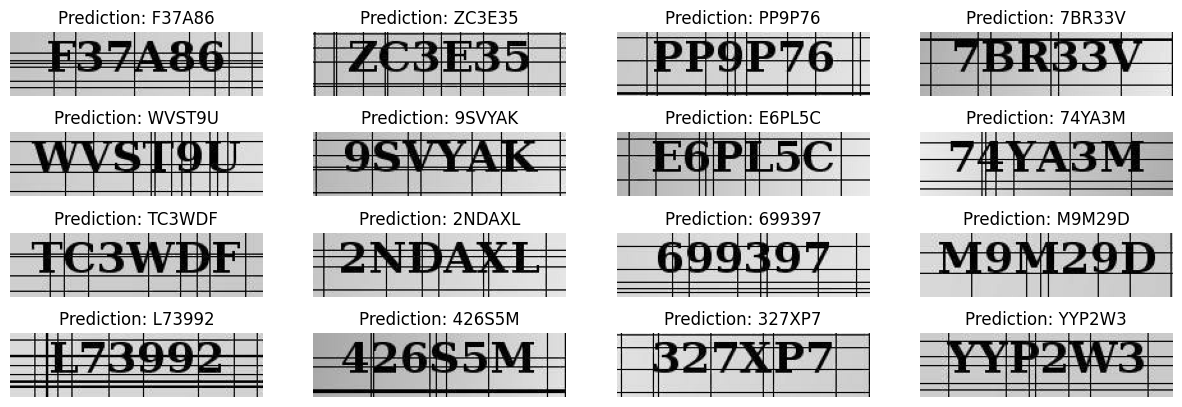

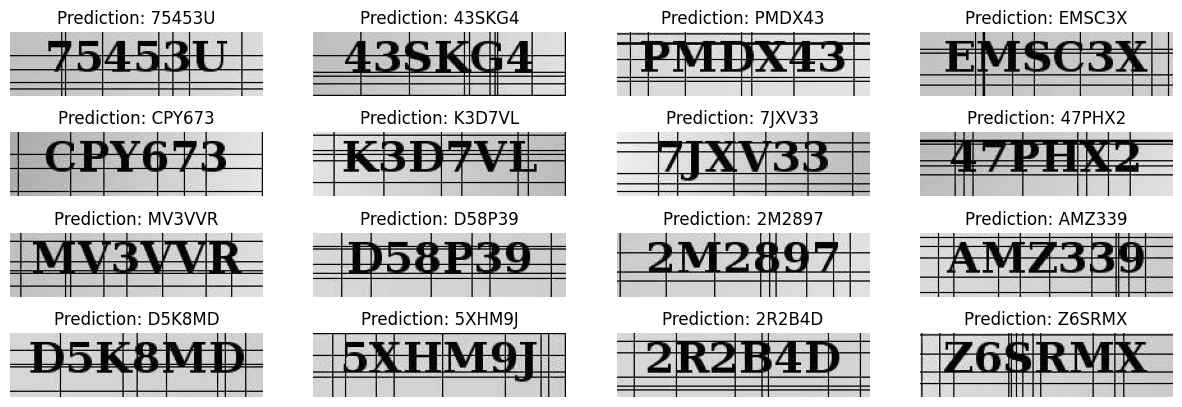

In [214]:
for batch in validation_dataset.take(10):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

        
    from sklearn.metrics import accuracy_score

    accuracy=accuracy_score(pred_texts,orig_texts)*100
    print("accuracy of prediction = {}".format(accuracy))


    
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img
        title = f"Prediction: {pred_texts[i]}"
        if i < 16:
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
plt.show()

In [215]:
model.save("/kaggle/working/")

In [216]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/fingerprint.pb (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/keras_metadata.pb (deflated 94%)
  adding: kaggle/working/saved_model.pb (deflated 90%)
  adding: kaggle/working/assets/ (stored 0%)
  adding: kaggle/working/variables/ (stored 0%)
  adding: kaggle/working/variables/variables.index (deflated 70%)
  adding: kaggle/working/variables/variables.data-00000-of-00001 (deflated 17%)


In [217]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip